<center> 
<img src="https://upload.wikimedia.org/wikipedia/commons/5/5c/Logo_Mondragon_Unibertsitatea.png" width="150" height="100" float ="left">
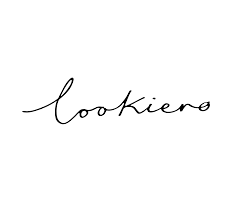    


---
<h3>Beñat Basabe, Jon Jarrín, June Pagaldai, Daniel Puente, Eneko Rentería | <font color='red'> Equipo Rojo<h3>

## Análisis inicial
En este script se detallarán los descriptivos obtenidos de este primer análisis. Tareas como detectar **cantidad de valores missing** o **outliers** entre otros.

### Carga de librerias 
---

- **General**

In [1]:
import pandas as pd
import numpy as np
import glob
import os

In [2]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkFiles
from pyspark.sql import functions as F
from pyspark.sql.functions import lit

from pyspark.sql.functions import split
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace

- **Strings**

In [3]:
from collections import Counter
from pyspark.sql.functions import when
import re

### Clases a utilizar
---

* Clase para **cargar de datos** (cd)

Se fijan los **directorios** de entrada y salida

In [4]:
dir_in, dir_out = "../../datos/datos_originales/", "../../datos/datos_desarrollo/"

spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

In [5]:
class carga_datos:
    ''' Cargar los datos desde el csv al python:
    - subir_tablas: se suben los dataframes con los titulos deseados. Como input: una lista de dfs y una lista de titulos.
    - subir_una_tabla: como input se especifica la tabla a subir.
    '''
    def __init__(self, dir_in = dir_in):
        self.dir_in = dir_in
        
    def subir_tablas(self, dir_in):
        path = os.getcwd()
        csv_files, dataframes_list = glob.glob(os.path.join(path, dir_in + "*.csv")), []

        for i in csv_files:
            temp_df = spark.read.csv(path = i, header = True, inferSchema = True)
            dataframes_list.append(temp_df)
        
        return dataframes_list
    
    def subir_una_tabla(self, dir_in, nombre_tabla):
        return pd.read_csv(os.path.join(dir_in, nombre_tabla + ".csv"))

In [6]:
cd = carga_datos ()

## Funciones a utilizar
---

- Función para **dar nombre** a la variable **family_id** mediante la variable title

In [7]:
def get_family_name(id_):
    
    filtered = product[product.family_id == id_]
    string = ' '.join(filtered.title).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

def get_family_name(id_):
    
    filtered = product.filter(product.family_id == id_)
    string = ' '.join([x['title'] for x in filtered.select('title').collect()]).lower()
    
    return id_, Counter(string.split()).most_common(1)[0][0]

____

In [8]:
dfs = cd.subir_tablas(dir_in)
titulos = os.listdir(dir_in)

In [9]:
size = cd.subir_una_tabla(dir_in, 'size')
size.to_csv(dir_out + 'size2.csv', sep = ';')
dfs[-1] = spark.read.csv(path = dir_out + 'size2.csv', header = True, inferSchema = True, sep = ';')

### Unión de *dataframes*

<center> 
<img  src="../imagenes/diagrama.PNG"> 


#### 1) df_total =  product variant + color + size + season

- **Season**: No utilizar
- **Size**: Utilizar solo la talla creada por *lookiero*
- **Color**: Utilizar solo el nombre del color

product_variant + size = 116 not used sizes NAN  
product_variant_size + color = 1 not used color (mixt) NAN

In [10]:
dfs[7].groupBy('channels').count().orderBy('count').show()
dfs[0].groupBy('number').count().orderBy('count').show()
dfs[3].groupBy('unit').count().orderBy('count').show()
dfs[-3].groupBy('season').count().orderBy('count').show()

+----------------+-----+
|        channels|count|
+----------------+-----+
|              []|  274|
|"[""LOOKIERO""]"| 2658|
+----------------+-----+

+------+-----+
|number|count|
+------+-----+
|     0|  163|
+------+-----+

+-----------+-----+
|       unit|count|
+-----------+-----+
| PERCENTAGE|    1|
|CENTIMETERS|    8|
|         \N|   52|
+-----------+-----+

+------+-----+
|season|count|
+------+-----+
|     9|20522|
|     7|22234|
|     8|22470|
+------+-----+



In [11]:
print(titulos)

['brand.csv', 'color.csv', 'datos_envios_MU.csv', 'feature.csv', 'feature_qualifier.csv', 'feature_value.csv', 'feature_value_family.csv', 'product.csv', 'product_feature_value.csv', 'product_feature_value_qualifier.csv', 'product_variant.csv', 'season.csv', 'size.csv']


In [12]:
def rename_columns(df, suffix):
    ''' Renombra las columnas de un dataframe.'''
    for names in df.schema.names: df = df.withColumnRenamed(names,names + suffix)
    return df


* We rename the columnas to have a suffix when we join

In [13]:
dfs[-1] = rename_columns(dfs[-1], '_size')
dfs[1] = rename_columns(dfs[1], '_color')

* Se junta los 2 dataframes en uno solo.

In [14]:
df_total = dfs[10].join(dfs[-1].select('id_size','lookiero_size'), dfs[10].size_id == dfs[-1].id_size, "inner").drop('id_size', 'size_id')
df_total = df_total.join(dfs[1].select('id_color', 'name_color'), df_total.color_id == dfs[1].id_color).drop('id_color', 'color_id', 'legacy_id')
df_total = df_total.withColumnRenamed("lookiero_size","size_lookiero") \
    .withColumnRenamed("name_color","color")

* Se modifica la variable size_lookiero para que tenga formato numérico

In [15]:
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ':').getItem(1))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '""', ''))
df_total = df_total.withColumn('size_lookiero', regexp_replace('size_lookiero', '}', ''))
df_total = df_total.withColumn('size_lookiero', split(df_total['size_lookiero'], ',').getItem(0))

In [16]:
print(df_total.collect()[0])

Row(id='e652ced0-571b-4ebe-a349-47155e190141', barcode=1281248, product_id='fa14ec83-b053-466e-afc0-ac164b77750f', season=9, stock=0, publishable='t', size_lookiero=' S', color='black')


#### 2) df_total += product

- **Product**: Dar nombre a la variable family_id y eliminar *legacy_id* y *channels*

product_variant + product = 41291 (63'3%) with no product_family or brand NAN  
NO SÉ SI SON COAT, SCARF O QUÉ...  
23935 SIN NAN

In [17]:
product = dfs[7].drop('legacy_id', 'channels')

unique_values_family =  [x['family_id'] for x in product.select('family_id').distinct().collect()]
parejas = dict(map(get_family_name, unique_values_family))
product = product.withColumn("product_family", product["family_id"])

# Este es el mapeado
for k, v in enumerate(unique_values_family): 
    product = product.withColumn('product_family', regexp_replace('product_family', v, str(parejas[v])))

# Se renombra la columna a la hora de unir
product = product.drop('family_id', 'title', '"""group"""')
product = rename_columns(product, '_product')

df_total = df_total.join(product, df_total.product_id == product.id_product).drop('product_id')

#### 3) df_total += brand

- **brand**: No utilizar variable number

df_total + brand = 0 NAN

In [18]:
brand = dfs[0].drop('number')
brand = brand.withColumnRenamed("id","id").withColumnRenamed("name","brand").withColumnRenamed("origin","brand_origin")
df_total = df_total.withColumn("publishable", when(df_total.publishable == "f",False).when(df_total.publishable == "t",True))
brand = rename_columns(brand, '_brand')
df_total = df_total.join(brand, df_total.brand_id_product == brand.id_brand).drop('brand_id_product','brand_id')

#### 4) values = feature values + feature (*value caracteristics*)

- **feature**: Multiple convertir en booleano (borrar??) y para poder eliminar la variable unit pasar los porcentajes a decimales (para diferenciarlos)

feature + feature_value = 1 value caracteristic not used NAN

In [19]:
feature = dfs[3]
feature = feature.withColumn("multiple", when(feature.multiple == "f",False).when(feature.multiple == "t",True))
column_names = ['id', 'feature_name', 'feature_type', 'feature_multiple', 'unit']

for k, v in enumerate(column_names):  feature = feature.withColumnRenamed(feature.schema.names[k], v)
feature_value = dfs[5]
feature = rename_columns(feature, '_values')
values = feature_value.join(feature, feature_value.feature_id == feature.id_values).drop('feature_id','id_values')

### **Hay que corregirlo pero no sé cómo**	

In [20]:
values.select('value').filter(values.unit_values == 'PERCENTAGE').withColumn('value', f.col('value')/100).show(4)

+-----+
|value|
+-----+
| 0.25|
| 0.36|
| 0.93|
| 0.46|
+-----+
only showing top 4 rows



feature_family no sirve para nada **creo** por lo que las siguientes celda en raw

#### 5) values + value family

In [21]:
for k, v in enumerate(['feature_family', 'feature_value_id']):  dfs[6] = dfs[6].withColumnRenamed(dfs[6].schema.names[k], v)
values = values.join(dfs[6], values.id == dfs[6].feature_value_id).drop('feature_value_id')


#### 6) product_values = values + product_feature_value

values + product_feature_value = 1420 (1'84%) caracteristics that has no product NAN

In [22]:
values = values.withColumnRenamed('id', 'id_values')
dfs[8] = dfs[8].withColumnRenamed('id', 'id_product_feature')
product_values = values.join(dfs[8], values.id_values == dfs[8].feature_value_id).drop('feature_value_id')

#### 7) product_values + df_total

products + features = 383 (0'06%) products without caracteristics NAN

In [23]:
df = df_total.join(product_values, df_total.id_product == product_values.product_id).drop('product_id')

id = Un único producto (se repite pork tiene diferentes features)  
id_product = El producto en general (niki manga larga)  
id_values = id de una característica
id_product_feature = id de la característica de un producto en general (id_product)

In [24]:
df.show(5)

+--------------------+-------+------+-----+-----------+-------------+-----+--------------------+----------------------+--------------------+-----------+------------------+--------------------+-----+-------------------+-------------------+-----------------------+-----------+--------------------+--------------------+
|                  id|barcode|season|stock|publishable|size_lookiero|color|          id_product|product_family_product|            id_brand|brand_brand|brand_origin_brand|           id_values|value|feature_name_values|feature_type_values|feature_multiple_values|unit_values|      feature_family|  id_product_feature|
+--------------------+-------+------+-----+-----------+-------------+-----+--------------------+----------------------+--------------------+-----------+------------------+--------------------+-----+-------------------+-------------------+-----------------------+-----------+--------------------+--------------------+
|498662e5-11e8-483...| 949392|     8|    0|      